## Create metadata from transcripts

create a metadata.csv containing:
utt_id, text, speaker, path


In [3]:
import os

BASE_DIR = r"G:\Libri Dataset\LibriTTS\train-clean-100"
OUTPUT_DIR = r"C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed"

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [5]:
metadata = []
for root, dirs, files in os.walk(BASE_DIR):
    for file in files:
        if file.endswith(".trans.tsv"):
            trans_path = os.path.join(root, file)
            speaker_id = root.split(os.sep)[-2]

            # Read the .trans.tsv file
            with open(trans_path, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    if len(parts) < 2:
                        continue
                    utt_id, text = parts[0], parts[1]

                    wav_path = os.path.join(root, utt_id + ".wav")
                    if os.path.exists(wav_path):
                        metadata.append({
                            'utt_id': utt_id,
                            'text': text.strip().lower(),
                            'speaker': speaker_id,
                            'path': wav_path
                        })

In [11]:
df = pd.DataFrame(metadata)
print("Sample rows:\n", df.head())

# Save as CSV
output_path = "metadata.csv"
df.to_csv(output_path, index=False)
print(f"Saved metadata to: {output_path}")


Sample rows:
                    utt_id                                               text  \
0  103_1241_000000_000001                      matthew cuthbert is surprised   
1  103_1241_000004_000002  in fact, he had looked at twenty very much as ...   
2  103_1241_000007_000001  "but there was a passenger dropped off for you...   
3  103_1241_000008_000001                         "it's a boy i've come for.   
4  103_1241_000012_000002  maybe they were out of boys of the brand you w...   

   speaker                                               path  split  
0      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  train  
1      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  train  
2      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  train  
3      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  train  
4      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  train  
Saved metadata to: metadata.csv


## FEATURE EXTRACTION

In [7]:
import os
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
from tqdm import tqdm

In [8]:
# Load metadata
METADATA_CSV = r"C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\metadata.csv"
OUTPUT_DIR = r"C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\features"

os.makedirs(OUTPUT_DIR, exist_ok=True)
df = pd.read_csv(METADATA_CSV)
df.head()


,utt_id,text,speaker,path
0,103_1241_000000_000001,matthew cuthbert is surprised,103,G:\Libri Dataset\LibriTTS\train-clean-100\103\...
1,103_1241_000004_000002,"in fact, he had looked at twenty very much as ...",103,G:\Libri Dataset\LibriTTS\train-clean-100\103\...
2,103_1241_000007_000001,"""but there was a passenger dropped off for you...",103,G:\Libri Dataset\LibriTTS\train-clean-100\103\...
3,103_1241_000008_000001,"""it's a boy i've come for.",103,G:\Libri Dataset\LibriTTS\train-clean-100\103\...
4,103_1241_000012_000002,maybe they were out of boys of the brand you w...,103,G:\Libri Dataset\LibriTTS\train-clean-100\103\...


In [9]:
# feature extraction functions

def extract_mel(y, sr, n_mels=80, hop_length=256, win_length=1024):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, 
                                         hop_length=hop_length, win_length=win_length)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db.T  # (frames, mel)

def extract_pitch(y, sr, hop_length):
    pitch = librosa.yin(y, fmin=50, fmax=300, sr=sr, hop_length=hop_length)
    return pitch

def extract_energy(y, frame_length, hop_length):
    energy = np.array([
        np.sqrt(np.sum(y[i:i+frame_length]**2))
        for i in range(0, len(y)-frame_length, hop_length)
    ])
    return energy


In [15]:
#Extract and save features

hop_length = 256
frame_length = 1024

for idx, row in tqdm(df.iterrows(), total=len(df)):
    utt_id = row['utt_id']
    wav_path = row['path']

    try:
        y, sr = librosa.load(wav_path, sr=None)

        mel = extract_mel(y, sr, hop_length=hop_length)
        pitch = extract_pitch(y, sr, hop_length)
        energy = extract_energy(y, frame_length, hop_length)

        min_len = min(mel.shape[0], len(pitch), len(energy))
        mel = mel[:min_len]
        pitch = pitch[:min_len]
        energy = energy[:min_len]

        np.save(os.path.join(OUTPUT_DIR, f"{utt_id}_mel.npy"), mel)
        np.save(os.path.join(OUTPUT_DIR, f"{utt_id}_pitch.npy"), pitch[:min_len])
        np.save(os.path.join(OUTPUT_DIR, f"{utt_id}_energy.npy"), energy[:min_len])

    except Exception as e:
        print(f"Error processing {utt_id}: {e}")


100%|██████████████████████████████████████████████████████████████████████████| 33236/33236 [1:39:18<00:00,  5.58it/s]


## Normalize Mel Features

In [27]:
FEATURE_DIR = os.path.join(OUTPUT_DIR, "features")  # updated path
mel_files = glob.glob(os.path.join(FEATURE_DIR, "*_mel.npy"))

print(f"Found {len(mel_files)} mel files")
all_mels = [np.load(f) for f in mel_files]

# Check for consistency
mel_shapes = [mel.shape for mel in all_mels]
assert all(shape[1] == mel_shapes[0][1] for shape in mel_shapes), "Mismatch in mel feature dimensions!"

# Compute normalization stats
concatenated_mels = np.concatenate(all_mels, axis=0)
mean = np.mean(concatenated_mels, axis=0)
std = np.std(concatenated_mels, axis=0)

# Save them back in OUTPUT_DIR (not features dir)
np.save(os.path.join(OUTPUT_DIR, "mel_mean.npy"), mean)
np.save(os.path.join(OUTPUT_DIR, "mel_std.npy"), std)

print("Saved mel_mean.npy and mel_std.npy to", OUTPUT_DIR)


Found 33236 mel files
Saved mel_mean.npy and mel_std.npy to C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed


In [28]:
# Load normalization stats
mean = np.load(os.path.join(OUTPUT_DIR, "mel_mean.npy"))
std = np.load(os.path.join(OUTPUT_DIR, "mel_std.npy"))

# Directory with unnormalized mel files
mel_files = glob.glob(os.path.join(FEATURE_DIR, "*_mel.npy"))

# Directory to save normalized features
norm_dir = os.path.join(OUTPUT_DIR, "normalized")
os.makedirs(norm_dir, exist_ok=True)

for mel_path in mel_files:
    mel = np.load(mel_path)

    # Normalize (broadcast along time axis)
    norm_mel = (mel - mean) / (std + 1e-8)

    # Save normalized mel
    base_name = os.path.basename(mel_path)
    np.save(os.path.join(norm_dir, base_name), norm_mel)

print(f"Saved normalized mel-spectrograms to: {norm_dir}")


Saved normalized mel-spectrograms to: C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\normalized


## Phonemization (Text → Phonemes)

In [10]:
from phonemizer import phonemize

In [18]:
# Convert all text in metadata to phonemes
df['phonemes'] = df['text'].apply(lambda x: phonemize(
    x,
    language='en-us',
    backend='espeak',   # <- IMPORTANT: use espeak-ng instead of espeak
    strip=True,
    preserve_punctuation=False,
    with_stress=False
))


RuntimeError: espeak not installed on your system

In [19]:
from phonemizer.backend.espeak import EspeakBackend

print(EspeakBackend.is_available())


ImportError: cannot import name 'EspeakBackend' from 'phonemizer.backend.espeak' (C:\Users\ADMIN\anaconda3\Lib\site-packages\phonemizer\backend\espeak\__init__.py)

In [9]:
import os

os.environ["PATH"] += os.pathsep + r"C:\Program Files (x86)\eSpeak\command_line"

from phonemizer import phonemize


In [24]:
!pip install phonemizer
!pip install espeakng


In [31]:
import os
import pandas as pd
from phonemizer import phonemize

# Path to your dataset
DATA_DIR = r"C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed"
TRANSCRIPT_FILE = os.path.join(DATA_DIR, "metadata.csv")

# Load transcripts
df = pd.read_csv(TRANSCRIPT_FILE, sep='|', header=None, names=['filename', 'text'])

# Convert all 'text' entries to string and handle NaN
df['text'] = df['text'].fillna('').astype(str)

# Remove rows where text is empty (optional)
df = df[df['text'].str.strip() != '']

print("Sample transcripts after cleaning:")
print(df.head())

# Convert text to phonemes
print("Phonemizing...")
df['phonemes'] = df['text'].apply(
    lambda x: phonemize(
        x,
        language='en-us',
        backend='espeak-mbrola',  # alternative backend
        strip=True,
        preserve_punctuation=True,
        with_stress=True
    )
)

# Save updated metadata
OUTPUT_FILE = os.path.join(DATA_DIR, "metadata_phonemized.csv")
df.to_csv(OUTPUT_FILE, sep='|', index=False)

print(f"Phonemization complete. Saved to {OUTPUT_FILE}")



Sample transcripts after cleaning:
Empty DataFrame
Columns: [filename, text]
Index: []
Phonemizing...
Phonemization complete. Saved to C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\metadata_phonemized.csv


In [32]:
import pandas as pd
import os

DATA_DIR = r"C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed"
TRANSCRIPT_FILE = os.path.join(DATA_DIR, "metadata.csv")

# Read without assumptions first
df_raw = pd.read_csv(TRANSCRIPT_FILE, header=None)
print("First 5 rows of raw file:")
print(df_raw.head())
print("\nShape:", df_raw.shape)


First 5 rows of raw file:
                        0                                                  1  \
0                  utt_id                                               text   
1  103_1241_000000_000001                      matthew cuthbert is surprised   
2  103_1241_000004_000002  in fact, he had looked at twenty very much as ...   
3  103_1241_000007_000001  "but there was a passenger dropped off for you...   
4  103_1241_000008_000001                         "it's a boy i've come for.   

         2                                                  3  
0  speaker                                               path  
1      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  
2      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  
3      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  
4      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  

Shape: (33237, 4)


In [36]:
from phonemizer import phonemize
phonemize("hello world", language="en-us", backend="espeak-ng")


RuntimeError: espeak-ng is not a supported backend, choose in espeak, espeak-mbrola, festival, segments.

In [33]:
import pandas as pd
import os
from phonemizer import phonemize

DATA_DIR = r"C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed"
TRANSCRIPT_FILE = os.path.join(DATA_DIR, "metadata.csv")

# Read the CSV without wrong separator assumptions
df = pd.read_csv(TRANSCRIPT_FILE)

# Make sure column names are correct
df.columns = ["utt_id", "text", "speaker", "path"]

# Drop any rows with missing text
df = df.dropna(subset=["text"])

# Clean text
df["text"] = df["text"].str.strip()

print("Sample transcripts after cleaning:")
print(df.head())

# Phonemization
print("Phonemizing...")
df["phonemes"] = phonemize(
    df["text"].tolist(),
    language="en-us",
    backend="espeak",
    strip=True,
    njobs=4
)
print("Phonemization complete.")

# Save to new file
output_file = os.path.join(DATA_DIR, "metadata_phonemized.csv")
df.to_csv(output_file, index=False)
print(f"Saved to {output_file}")


Sample transcripts after cleaning:
                   utt_id                                               text  \
0  103_1241_000000_000001                      matthew cuthbert is surprised   
1  103_1241_000004_000002  in fact, he had looked at twenty very much as ...   
2  103_1241_000007_000001  "but there was a passenger dropped off for you...   
3  103_1241_000008_000001                         "it's a boy i've come for.   
4  103_1241_000012_000002  maybe they were out of boys of the brand you w...   

   speaker                                               path  
0      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  
1      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  
2      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  
3      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  
4      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...  
Phonemizing...


RuntimeError: espeak not installed on your system

In [10]:
import glob
import numpy as np


In [11]:
# Paths
OUTPUT_DIR = r"C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed"

# Get all transcript files
transcript_files = glob.glob(os.path.join(OUTPUT_DIR, "*_transcript.txt"))

# Phonemization and saving
for transcript_file in transcript_files:
    base_name = os.path.basename(transcript_file).replace("_transcript.txt", "")
    with open(transcript_file, "r", encoding="utf-8") as f:
        text = f.read().strip()

    # Phonemize the text using espeak backend
    phonemes = phonemize(
        text,
        language='en-us',
        backend='espeak',              
        strip=True,
        preserve_punctuation=False,
        with_stress=False
    )

    # Save phonemes to a file
    phoneme_file = os.path.join(OUTPUT_DIR, f"{base_name}_phonemes.txt")
    with open(phoneme_file, "w", encoding="utf-8") as f:
        f.write(phonemes)

    print(f"Phonemes saved for: {base_name}")

In [12]:
df.to_csv(os.path.join(OUTPUT_DIR, "metadata_phonemes.csv"), index=False)

In [14]:
os.environ["PATH"] += os.pathsep + r"C:\Program Files (x86)\eSpeak\command_line"

# Directories
OUTPUT_DIR = r"C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed"
FEATURE_DIR = os.path.join(OUTPUT_DIR, "features")

In [15]:
# Find all transcript files
transcript_files = glob.glob(os.path.join(OUTPUT_DIR, "*_transcript.txt"))
phoneme_dict = {}

for transcript_file in transcript_files:
    base_name = os.path.basename(transcript_file).replace("_transcript.txt", "")
    with open(transcript_file, "r", encoding="utf-8") as f:
        text = f.read().strip()

    # Phonemize using eSpeak
    phonemes = phonemize(
        text,
        language='en-us',
        backend='espeak',
        strip=True,
        preserve_punctuation=False,
        with_stress=False
    )

    # Save phonemes to file
    phoneme_file = os.path.join(OUTPUT_DIR, f"{base_name}_phonemes.txt")
    with open(phoneme_file, "w", encoding="utf-8") as f:
        f.write(phonemes)

    phoneme_dict[base_name] = phonemes
    print(f"Phonemes saved for: {base_name}")


In [22]:
# Load your existing metadata CSV
df = pd.read_csv(os.path.join(OUTPUT_DIR, "metadata.csv"))

# Use utt_id (or adjust if needed to match your filenames in phoneme_dict)
df['phonemes'] = df['utt_id'].apply(lambda x: phoneme_dict.get(str(x), ""))

# Save updated metadata
df.to_csv(os.path.join(OUTPUT_DIR, "metadata_phonemes.csv"), index=False)


### Using g2p-en

In [37]:
!pip install g2p-en

In [39]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')

from g2p_en import G2p

g2p = G2p()
print(g2p("hello world"))

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['HH', 'AH0', 'L', 'OW1', ' ', 'W', 'ER1', 'L', 'D']


In [19]:
import os
import pandas as pd
from g2p_en import G2p

# Paths
input_csv = r"C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\metadata.csv"
output_csv = r"C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\metadata_phonemized.csv"

# Load cleaned transcripts
df = pd.read_csv(input_csv)

# Initialize G2P converter
g2p = G2p()

# Apply phonemization
phonemized_texts = []
for text in df['text']:
    if isinstance(text, str) and text.strip():
        phones = g2p(text)
        # Join phonemes with spaces, remove multiple spaces
        phonemized_texts.append(" ".join([p for p in phones if p.strip()]))
    else:
        phonemized_texts.append("")

# Save results
df['phonemized'] = phonemized_texts
df.to_csv(output_csv, index=False)

print(f"Phonemization complete. Saved to {output_csv}")


Phonemization complete. Saved to C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\metadata_phonemized.csv


#### split speakers

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [21]:
unique_speakers = df['speaker'].unique()
train_speakers, test_speakers = train_test_split(unique_speakers, test_size=0.1, random_state=42)

df['split'] = df['speaker'].apply(lambda x: 'test' if x in test_speakers else 'train')

df[df['split'] == 'train'].to_csv(os.path.join(OUTPUT_DIR, "train_metadata.csv"), index=False)
df[df['split'] == 'test'].to_csv(os.path.join(OUTPUT_DIR, "test_metadata.csv"), index=False)
print("Train/test split saved.")

Train/test split saved.


In [22]:
train_meta = pd.read_csv(os.path.join(OUTPUT_DIR, "train_metadata.csv"))

phonemized = train_meta['phonemized'].dropna().tolist()
vocab = sorted(set(" ".join(phonemized).split()))

phoneme_to_id = {p: i+1 for i, p in enumerate(vocab)}  # 0 = padding
id_to_phoneme = {i: p for p, i in phoneme_to_id.items()}

np.save(os.path.join(OUTPUT_DIR, "phoneme_to_id.npy"), phoneme_to_id)
np.save(os.path.join(OUTPUT_DIR, "id_to_phoneme.npy"), id_to_phoneme)

print(f"Saved phoneme vocab. Size: {len(phoneme_to_id)}")

Saved phoneme vocab. Size: 77


In [2]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


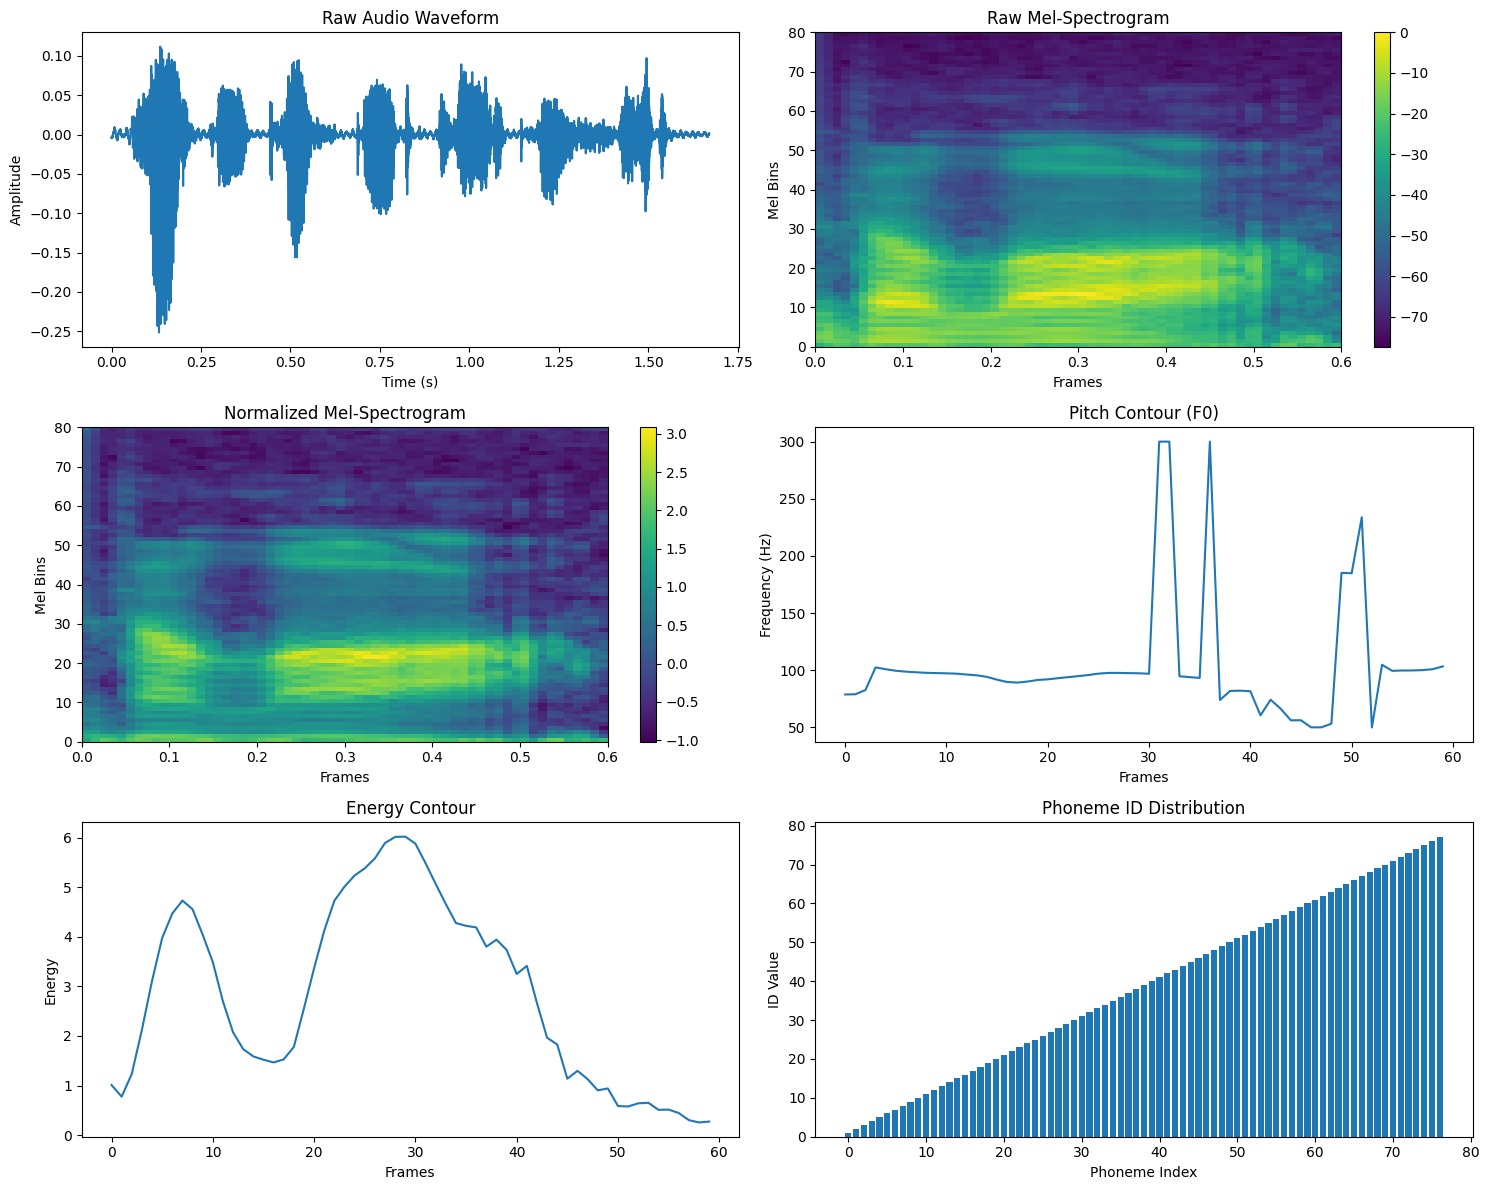

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

def visualize_data_pipeline():
    """Visualize the data processing pipeline"""
    # 1. Show raw audio waveform
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # Load a sample audio file
    wav_files = list(Path(r"G:/Libri Dataset/LibriTTS/train-clean-100").glob("**/*.wav"))
    if wav_files:
        import librosa
        audio, sr = librosa.load(wav_files[0], sr=22050)
        time = np.arange(len(audio)) / sr
        
        axes[0,0].plot(time, audio)
        axes[0,0].set_title("Raw Audio Waveform")
        axes[0,0].set_xlabel("Time (s)")
        axes[0,0].set_ylabel("Amplitude")
    
    # 2. Show mel-spectrogram
    mel_files = list(Path(r"C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed/features").glob("*_mel.npy"))
    if mel_files:
        mel = np.load(mel_files[0])
        im = axes[0,1].imshow(mel.T, aspect='auto', origin='lower', 
                             extent=[0, mel.shape[0]/100, 0, 80])
        axes[0,1].set_title("Raw Mel-Spectrogram")
        axes[0,1].set_xlabel("Frames")
        axes[0,1].set_ylabel("Mel Bins")
        plt.colorbar(im, ax=axes[0,1])
    
    # 3. Show normalized mel
    norm_mel_files = list(Path(r"C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed/normalized").glob("*_mel.npy"))
    if norm_mel_files:
        norm_mel = np.load(norm_mel_files[0])
        im = axes[1,0].imshow(norm_mel.T, aspect='auto', origin='lower',
                             extent=[0, norm_mel.shape[0]/100, 0, 80])
        axes[1,0].set_title("Normalized Mel-Spectrogram")
        axes[1,0].set_xlabel("Frames")
        axes[1,0].set_ylabel("Mel Bins")
        plt.colorbar(im, ax=axes[1,0])
    
    # 4. Show pitch contour
    pitch_files = list(Path(r"C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed/features").glob("*_pitch.npy"))
    if pitch_files:
        pitch = np.load(pitch_files[0])
        valid_pitch = pitch[pitch > 0]  # Remove unvoiced frames
        axes[1,1].plot(valid_pitch)
        axes[1,1].set_title("Pitch Contour (F0)")
        axes[1,1].set_xlabel("Frames")
        axes[1,1].set_ylabel("Frequency (Hz)")
    
    # 5. Show energy
    energy_files = list(Path(r"C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed/features").glob("*_energy.npy"))
    if energy_files:
        energy = np.load(energy_files[0])
        axes[2,0].plot(energy)
        axes[2,0].set_title("Energy Contour")
        axes[2,0].set_xlabel("Frames")
        axes[2,0].set_ylabel("Energy")
    
    # 6. Show phoneme distribution
    try:
        phoneme_to_id = np.load(Path(r"C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed/phoneme_to_id.npy"), 
                               allow_pickle=True).item()
        axes[2,1].bar(range(len(phoneme_to_id)), list(phoneme_to_id.values()))
        axes[2,1].set_title("Phoneme ID Distribution")
        axes[2,1].set_xlabel("Phoneme Index")
        axes[2,1].set_ylabel("ID Value")
    except:
        axes[2,1].text(0.5, 0.5, "Phoneme data not available", ha='center')
    
    plt.tight_layout()
    plt.show()

visualize_data_pipeline()